## Task 3: Model Training

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import joblib
import os

### 1. Choose Appropriate Features for the Model


####  Correlation Heatmap


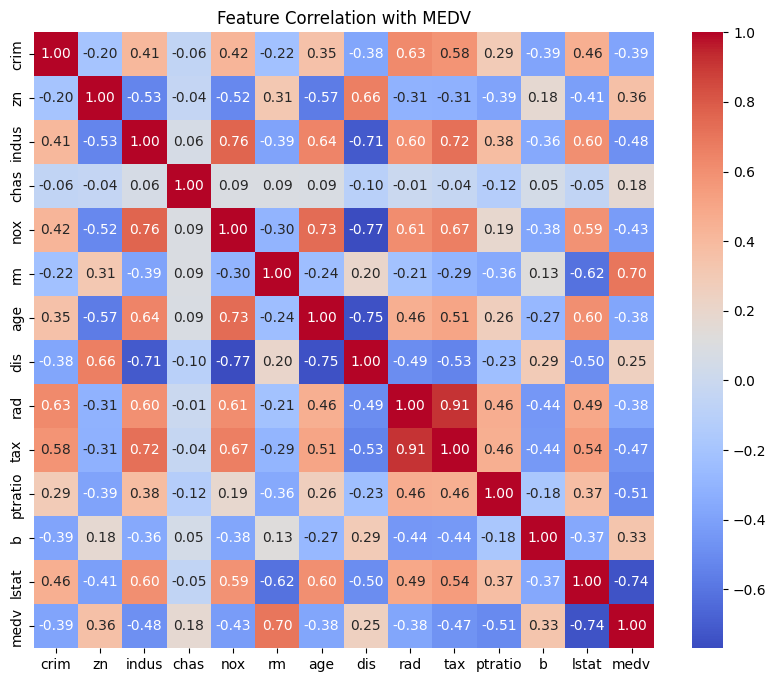

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("../data/boston_housing.csv")

# Compute correlation matrix
corr_matrix = df.corr()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation with MEDV")
plt.show()


####  Recursive Feature Elimination (RFE)


In [3]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import numpy as np

# Define X and y
X = df.drop(columns=['medv'])  # Remove target variable
y = df['medv']

# Handle missing values
X.fillna(X.median(), inplace=True)  # Replace NaNs with column medians

# Instantiate model
lr = LinearRegression()

# Perform Recursive Feature Elimination
selector = RFE(lr, n_features_to_select=5)  # Select top 5 features (adjust this number if needed)
selector.fit(X, y)

# Get selected features
selected_features = X.columns[selector.support_]
print("Selected Features:", list(selected_features)) 


Selected Features: ['chas', 'nox', 'rm', 'dis', 'ptratio']


### 2. Train a Linear Regression Model


#### Prepare the Data

In [4]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv('../data/boston_housing.csv')

# Features and target variable selection
X = df[['chas', 'nox', 'rm', 'dis', 'ptratio']]  # Features
y = df['medv']  # Target variable

# Handle missing values by imputing with the median
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)  # Apply imputation to features
y_imputed = imputer.fit_transform(y.values.reshape(-1, 1))  # Apply imputation to target variable


#### Split the Data into Training and Testing Sets

In [5]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=42)

# Check the shape of the resulting splits
print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")


Training set shape: (404, 5), Testing set shape: (102, 5)


#### Train the Linear Regression Model


In [6]:
from sklearn.linear_model import LinearRegression

# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Model coefficients and intercept
print(f"Model Coefficients: {model.coef_}")
print(f"Model Intercept: {model.intercept_}")


Model Coefficients: [[  4.61701255 -32.24282194   6.88899438  -0.999519    -1.17964851]]
Model Intercept: [22.31272606]


#### Make Predictions and Evaluate the Model

In [7]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on the training and testing data
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate performance using RMSE and R²
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

# Print evaluation results
print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")
print(f"Training R²: {train_r2}")
print(f"Testing R²: {test_r2}")


Training RMSE: 5.510012147463611
Testing RMSE: 5.811829028892669
Training R²: 0.6505232611401528
Testing R²: 0.5394025072014197


#### Hyperparameter Tuning for Ridge and Lasso Regression

In [8]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the alpha range for Ridge and Lasso
alpha_range = np.logspace(-6, 6, 13)  # Values from 10^-6 to 10^6

# Define Ridge regression and its parameter grid
ridge = Ridge()
ridge_param_grid = {'alpha': alpha_range}

# Define Lasso regression and its parameter grid
lasso = Lasso()
lasso_param_grid = {'alpha': alpha_range}

# Perform Ridge regression hyperparameter tuning with cross-validation
ridge_grid_search = GridSearchCV(ridge, ridge_param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
ridge_grid_search.fit(X_train, y_train)

# Perform Lasso regression hyperparameter tuning with cross-validation
lasso_grid_search = GridSearchCV(lasso, lasso_param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
lasso_grid_search.fit(X_train, y_train)

# Best alpha for Ridge and Lasso
best_ridge_alpha = ridge_grid_search.best_params_['alpha']
best_lasso_alpha = lasso_grid_search.best_params_['alpha']

print(f"Best alpha for Ridge: {best_ridge_alpha}")
print(f"Best alpha for Lasso: {best_lasso_alpha}")

# Evaluate the performance of Ridge and Lasso with the best alpha
ridge_best_model = ridge_grid_search.best_estimator_
lasso_best_model = lasso_grid_search.best_estimator_

# Predict on the test set
ridge_y_pred = ridge_best_model.predict(X_test)
lasso_y_pred = lasso_best_model.predict(X_test)

# Evaluate performance using RMSE
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_y_pred))
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_y_pred))

print(f"Ridge Regression RMSE with best alpha: {ridge_rmse}")
print(f"Lasso Regression RMSE with best alpha: {lasso_rmse}")


Best alpha for Ridge: 0.01
Best alpha for Lasso: 0.0001
Ridge Regression RMSE with best alpha: 5.810879555657069
Lasso Regression RMSE with best alpha: 5.811638729328176


#### Cross-Validation

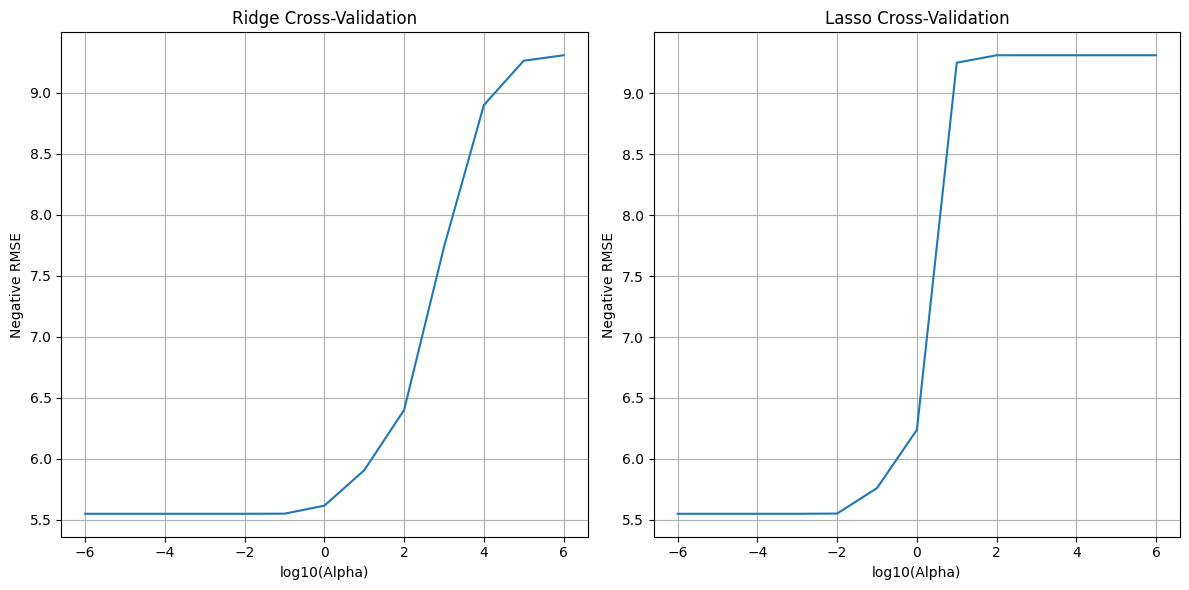

In [9]:
import matplotlib.pyplot as plt

# Plot the cross-validation results for Ridge and Lasso
plt.figure(figsize=(12, 6))

# Ridge results
plt.subplot(1, 2, 1)
plt.plot(np.log10(ridge_grid_search.cv_results_['param_alpha'].data), -ridge_grid_search.cv_results_['mean_test_score'], label='Ridge CV')
plt.xlabel('log10(Alpha)')
plt.ylabel('Negative RMSE')
plt.title('Ridge Cross-Validation')
plt.grid(True)

# Lasso results
plt.subplot(1, 2, 2)
plt.plot(np.log10(lasso_grid_search.cv_results_['param_alpha'].data), -lasso_grid_search.cv_results_['mean_test_score'], label='Lasso CV')
plt.xlabel('log10(Alpha)')
plt.ylabel('Negative RMSE')
plt.title('Lasso Cross-Validation')
plt.grid(True)

plt.tight_layout()
plt.show()


### Save the trained models


In [12]:
import os
import joblib

# Define the path to the 'models' directory in the root folder
models_dir = "../models"

# Check if 'models' directory exists; if not, create it
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Save the models in the root 'models' directory
joblib.dump(model, os.path.join(models_dir, "linear_regression_model.pkl"))
joblib.dump(ridge_best_model, os.path.join(models_dir, "ridge_model.pkl"))
joblib.dump(lasso_best_model, os.path.join(models_dir, "lasso_model.pkl"))

print("Models trained and saved successfully!")

Models trained and saved successfully!
